# Learn VAE on Game datasets


## Standard-Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install keras


You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.



## Loading Datasets

- Skiing datasets will be used. Use the first 4 Worlds for training and the others for testing


In [49]:

game_name = "Skiing"
output = "v0"

downsampled = []
#original = []
actions = []
rewards = []

import os
record_files = [filename for filename in os.listdir(f'./record/{game_name}')
                    if os.path.isfile(f"./record/{game_name}/{filename}") and filename.startswith(f"record_{game_name}")]
for file in record_files[0:5]:
    print("load file: ", file)
    data = np.load(f"./record/{game_name}/{file}", allow_pickle=True)
    if len(downsampled) == 0:
        downsampled = data["obs_downsampled"]
        #original = data["obs_original"]
        actions = data["actions"]
        rewards = data["rewards"]
    else:
        downsampled = np.concatenate((downsampled, data["obs_downsampled"]))
        #original = np.concatenate((original, data["obs_original"]))
        actions = np.concatenate((actions, data["actions"]))
        rewards = np.concatenate((rewards, data["rewards"]))

obs_train_downsampled = downsampled / 255.
#obs_train = original / 255.
actions_train = actions
rewards_train = rewards

print("loaded obs_train_downsampled: ", downsampled.shape)
#print("loaded obs_train: ", original.shape)
print("loaded actions_train: ", actions.shape)
print("loaded rewards_train: ", rewards.shape)


downsampled = []
#original = []
actions = []
rewards = []

for file in record_files[10:15]:
    print("load file: ", file)
    data = np.load(f"./record/{game_name}/{file}", allow_pickle=True)
    if len(downsampled) == 0:
        downsampled = data["obs_downsampled"]
        #original = data["obs_original"]
        actions = data["actions"]
        rewards = data["rewards"]
    else:
        downsampled = np.concatenate((downsampled, data["obs_downsampled"]))
        #original = np.concatenate((original, data["obs_original"]))
        actions = np.concatenate((actions, data["actions"]))
        rewards = np.concatenate((rewards, data["rewards"]))

obs_test_downsampled = downsampled / 255.
#obs_test = original / 255.
actions_test = actions
rewards_test = rewards

print("loaded obs_test_downsampled: ", downsampled.shape)
#print("loaded obs_test: ", original.shape)
print("loaded actions_test: ", actions.shape)
print("loaded rewards_test: ", rewards.shape)


load file:  record_Skiing_v0_0.npz
load file:  record_Skiing_v0_1.npz
load file:  record_Skiing_v0_10.npz
load file:  record_Skiing_v0_100.npz
load file:  record_Skiing_v0_11.npz
loaded obs_train_downsampled:  (7884, 64, 64, 3)
loaded actions_train:  (7884,)
loaded rewards_train:  (7884,)
load file:  record_Skiing_v0_17.npz
load file:  record_Skiing_v0_18.npz
load file:  record_Skiing_v0_19.npz
load file:  record_Skiing_v0_2.npz
load file:  record_Skiing_v0_20.npz
loaded obs_test_downsampled:  (8171, 64, 64, 3)
loaded actions_test:  (8171,)
loaded rewards_test:  (8171,)


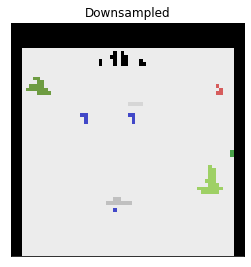

(7884, 64, 64, 3)


In [50]:
import random
index = random.choice(range(len(obs_train_downsampled)))
plt.imshow(obs_train_downsampled[index,:,:,:])
plt.title("Downsampled")
plt.tight_layout()
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.show()

print(obs_train_downsampled.shape)


In [2]:
## Simple Auto-Encoder

def pad_along_axis(array: np.ndarray, target_length, axis=0):

    npad = [(0, 0) for _ in range(len(array.shape))]

    for axes in axis:
        
        pad_size = (target_length - array.shape[axes])
        if pad_size % 2 == 0:
            npad[axes] = (pad_size//2, pad_size//2)
        else:
            npad[axes] = (pad_size//2, pad_size//2+1)

    b = np.pad(array, pad_width=npad, mode='constant', constant_values=0)

    return b

In [7]:

import numpy as np

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(64, 64, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = UpSampling2D((2, 2))(encoded)
x = Conv2D(16, (3, 3), activation='sigmoid', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [9]:
autoencoder.fit(obs_train_downsampled, obs_train_downsampled,
                epochs=10,
                batch_size=100,
                shuffle=True,
                validation_data=(obs_test_downsampled, obs_test_downsampled))


Instructions for updating:
Use tf.cast instead.
Train on 8418 samples, validate on 8444 samples
Epoch 1/10
8418/8418 [==============================] - 82s 10ms/step - loss: 0.4474 - val_loss: 0.3000
Epoch 2/10
8418/8418 [==============================] - 79s 9ms/step - loss: 0.2717 - val_loss: 0.2549
Epoch 3/10
8418/8418 [==============================] - 75s 9ms/step - loss: 0.2487 - val_loss: 0.2459
Epoch 4/10
8418/8418 [==============================] - 76s 9ms/step - loss: 0.2413 - val_loss: 0.2382
Epoch 5/10
8418/8418 [==============================] - 78s 9ms/step - loss: 0.2377 - val_loss: 0.2379
Epoch 6/10
8418/8418 [==============================] - 78s 9ms/step - loss: 0.2359 - val_loss: 0.2351
Epoch 7/10
8418/8418 [==============================] - 77s 9ms/step - loss: 0.2349 - val_loss: 0.2347
Epoch 8/10
8418/8418 [==============================] - 76s 9ms/step - loss: 0.2343 - val_loss: 0.2336
Epoch 9/10
8418/8418 [==============================] - 76s 9ms/step - loss: 0.

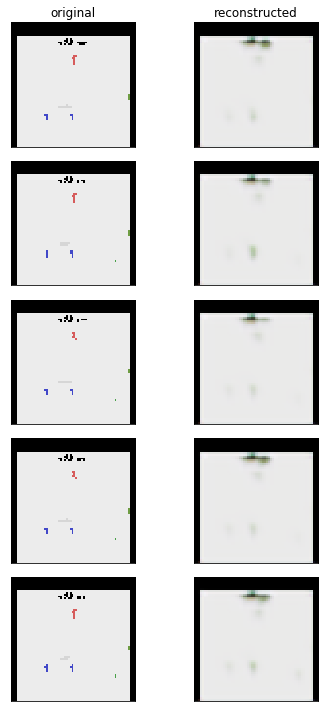

In [10]:

decoded_imgs = autoencoder.predict(obs_test_downsampled)

n = 5
_, ax = plt.subplots(n,2, figsize=(6,10))

for i in range(n):
    # display original
    ax[i,0].imshow(obs_test_downsampled[i,:,:,:].reshape(64, 64, 3))
    ax[i,0].get_xaxis().set_visible(False)
    ax[i,0].get_yaxis().set_visible(False)
    
    # display reconstruction
    ax[i,1].imshow(decoded_imgs[i,:,:,:].reshape(64, 64, 3))
    ax[i,1].get_xaxis().set_visible(False)
    ax[i,1].get_yaxis().set_visible(False)
    
    if i == 0:
        ax[i,0].set_title("original")
        ax[i,1].set_title("reconstructed")
        
plt.tight_layout()
plt.show()
    

In [ ]:
print(actions[0:4])




## Simple Convolutional Variational Auto-Encoder


In [2]:

import numpy as np
import json
import tensorflow as tf
import os


def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()


class ConvVAE(object):
  def __init__(self, z_size=32, batch_size=1, learning_rate=0.0001, kl_tolerance=0.5, is_training=False,
               reuse=False, gpu_mode=False):
    self.z_size = z_size
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.is_training = is_training
    self.kl_tolerance = kl_tolerance
    self.reuse = reuse

    with tf.variable_scope('conv_vae', reuse=self.reuse):
      if not gpu_mode:
        with tf.device('/cpu:0'):
          tf.logging.info('Model using cpu.')
          self._build_graph()
      else:
        tf.logging.info('Model using gpu.')
        self._build_graph()
    self._init_session()

  def _build_graph(self):
    self.g = tf.Graph()
    with self.g.as_default():

      self.x = tf.placeholder(tf.float32, shape=[None, 64, 64, 3])

      # Encoder
      h = tf.layers.conv2d(self.x, 32, 4, strides=2, activation=tf.nn.relu, name="enc_conv1")
      h = tf.layers.conv2d(h, 64, 4, strides=2, activation=tf.nn.relu, name="enc_conv2")
      h = tf.layers.conv2d(h, 128, 4, strides=2, activation=tf.nn.relu, name="enc_conv3")
      h = tf.layers.conv2d(h, 256, 4, strides=2, activation=tf.nn.relu, name="enc_conv4")
      h = tf.reshape(h, [-1, 2*2*256])

      # VAE
      self.mu = tf.layers.dense(h, self.z_size, name="enc_fc_mu")
      self.logvar = tf.layers.dense(h, self.z_size, name="enc_fc_log_var")
      self.sigma = tf.exp(self.logvar / 2.0)
      self.epsilon = tf.random_normal([self.batch_size, self.z_size])
      self.z = self.mu + self.sigma * self.epsilon

      # Decoder
      h = tf.layers.dense(self.z, 4*256, name="dec_fc")
      h = tf.reshape(h, [-1, 1, 1, 4*256])
      h = tf.layers.conv2d_transpose(h, 128, 5, strides=2, activation=tf.nn.relu, name="dec_deconv1")
      h = tf.layers.conv2d_transpose(h, 64, 5, strides=2, activation=tf.nn.relu, name="dec_deconv2")
      h = tf.layers.conv2d_transpose(h, 32, 6, strides=2, activation=tf.nn.relu, name="dec_deconv3")
      self.y = tf.layers.conv2d_transpose(h, 3, 6, strides=2, activation=tf.nn.sigmoid, name="dec_deconv4")
      
      # train ops
      if self.is_training:
        self.global_step = tf.Variable(0, name='global_step', trainable=False)

        eps = 1e-6 # avoid taking log of zero
        
        # reconstruction loss
        self.r_loss = tf.reduce_sum(
          tf.square(self.x - self.y),
          reduction_indices = [1,2,3]
        )
        self.r_loss = tf.reduce_mean(self.r_loss)

        # augmented kl loss per dim
        self.kl_loss = - 0.5 * tf.reduce_sum(
          (1 + self.logvar - tf.square(self.mu) - tf.exp(self.logvar)),
          reduction_indices = 1
        )
        self.kl_loss = tf.maximum(self.kl_loss, self.kl_tolerance * self.z_size)
        self.kl_loss = tf.reduce_mean(self.kl_loss)
        
        self.loss = self.r_loss + self.kl_loss
        
        # training
        self.lr = tf.Variable(self.learning_rate, trainable=False)
        self.optimizer = tf.train.AdamOptimizer(self.lr)
        grads = self.optimizer.compute_gradients(self.loss) # can potentially clip gradients here.

        self.train_op = self.optimizer.apply_gradients(
          grads, global_step=self.global_step, name='train_step')

      # initialize vars
      self.init = tf.global_variables_initializer()
      
      t_vars = tf.trainable_variables()
      self.assign_ops = {}
      for var in t_vars:
        #if var.name.startswith('conv_vae'):
        pshape = var.get_shape()
        pl = tf.placeholder(tf.float32, pshape, var.name[:-2]+'_placeholder')
        assign_op = var.assign(pl)
        self.assign_ops[var] = (assign_op, pl)


  def _init_session(self):
    """Launch TensorFlow session and initialize variables"""
    self.sess = tf.Session(graph=self.g)
    self.sess.run(self.init)
      
  def close_sess(self):
    """ Close TensorFlow session """
    self.sess.close()
      
  def encode(self, x):
    return self.sess.run(self.z, feed_dict={self.x: x})
  
  def encode_mu_logvar(self, x):
    (mu, logvar) = self.sess.run([self.mu, self.logvar], feed_dict={self.x: x})
    return mu, logvar
  
  def decode(self, z):
    return self.sess.run(self.y, feed_dict={self.z: z})
  
  def decode_mu_logvar(self, mu, logvar):
    return self.sess.run(self.y, feed_dict={self.mu: mu, self.logvar:logvar})
  
  def get_model_params(self):
    # get trainable params.
    model_names = []
    model_params = []
    model_shapes = []
    with self.g.as_default():
      t_vars = tf.trainable_variables()
      for var in t_vars:
        #if var.name.startswith('conv_vae'):
        param_name = var.name
        p = self.sess.run(var)
        model_names.append(param_name)
        params = np.round(p*10000).astype(np.int).tolist()
        model_params.append(params)
        model_shapes.append(p.shape)
    return model_params, model_shapes, model_names
  
  def get_random_model_params(self, stdev=0.5):
    # get random params.
    _, mshape, _ = self.get_model_params()
    rparam = []
    for s in mshape:
      #rparam.append(np.random.randn(*s)*stdev)
      rparam.append(np.random.standard_cauchy(s)*stdev) # spice things up
    return rparam
  
  def set_model_params(self, params):
    with self.g.as_default():
      t_vars = tf.trainable_variables()
      idx = 0
      for var in t_vars:
        #if var.name.startswith('conv_vae'):
        pshape = tuple(var.get_shape().as_list())
        p = np.array(params[idx])
        assert pshape == p.shape, "inconsistent shape"
        assign_op, pl = self.assign_ops[var]
        self.sess.run(assign_op, feed_dict={pl.name: p/10000.})
        idx += 1
              
  def load_json(self, jsonfile='vae.json'):
    with open(jsonfile, 'r') as f:
      params = json.load(f)
    self.set_model_params(params)
      
  def save_json(self, jsonfile='vae.json'):
    model_params, model_shapes, model_names = self.get_model_params()
    qparams = []
    for p in model_params:
      qparams.append(p)
    with open(jsonfile, 'wt') as outfile:
      json.dump(qparams, outfile, sort_keys=True, indent=0, separators=(',', ': '))
          
  def set_random_params(self, stdev=0.5):
    rparam = self.get_random_model_params(stdev)
    self.set_model_params(rparam)
      
  def save_model(self, model_save_path):
    sess = self.sess
    with self.g.as_default():
      saver = tf.train.Saver(tf.global_variables())
    checkpoint_path = os.path.join(model_save_path, 'vae')
    tf.logging.info('saving model %s.', checkpoint_path)
    saver.save(sess, checkpoint_path, 0) # just keep one
      
  def load_checkpoint(self, checkpoint_path):
    sess = self.sess
    with self.g.as_default():
      saver = tf.train.Saver(tf.global_variables())
    ckpt = tf.train.get_checkpoint_state(checkpoint_path)
    print('loading model', ckpt.model_checkpoint_path)
    tf.logging.info('Loading model %s.', ckpt.model_checkpoint_path)
    saver.restore(sess, ckpt.model_checkpoint_path)



In [3]:

# Hyperparameters for ConvVAE
z_size=32
batch_size=64
learning_rate=0.0001
kl_tolerance=0.5

vae = ConvVAE(z_size=z_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              kl_tolerance=kl_tolerance,
              is_training=True,
              reuse=False,
              gpu_mode=True)

reset_graph()
total_epochs = 0


INFO:tensorflow:Model using gpu.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use tf.cast instead.


In [36]:

NUM_EPOCH = 50
dataset = obs_train_downsampled

total_length = len(dataset)

num_batches = int(np.floor(total_length/batch_size))
print(f"num_batches per epoch = {num_batches}")

# train loop:

print("train", "step", "loss", "recon_loss", "kl_loss")
for epoch in range(NUM_EPOCH):
  print(f"epoch: {epoch}")
  np.random.shuffle(dataset)
  for idx in range(num_batches):
    batch = dataset[idx*batch_size:(idx+1)*batch_size]

    obs = batch.astype(np.float)
    #obs = pad_along_axis(obs, 256, axis=[1,2])

    feed = {vae.x: obs,}
    (train_loss, r_loss, kl_loss, train_step, _) = vae.sess.run([
      vae.loss, vae.r_loss, vae.kl_loss, vae.global_step, vae.train_op
    ], feed)
  
    if ((train_step+1) % 10 == 0):
      print("step", (train_step+1), train_loss, r_loss, kl_loss)
  
  total_epochs += 1  
  vae.save_json(f"tf_vae/vae_epochs_{game_name}_{total_epochs}.json")
         

num_batches per epoch = 131
train step loss recon_loss kl_loss
epoch: 0
step 14420 39.216694 23.10323 16.113464
step 14430 38.800808 22.670158 16.13065
step 14440 38.331726 22.08236 16.249369
step 14450 37.49658 21.353058 16.14352
step 14460 38.25046 22.091995 16.158466
step 14470 38.895622 22.768852 16.12677
step 14480 40.04335 23.974073 16.069275
step 14490 38.95134 22.923458 16.027882
step 14500 38.765434 22.727114 16.038322
step 14510 38.989784 22.95263 16.037155
step 14520 39.31784 23.187262 16.130577
step 14530 36.411102 20.317078 16.094025
step 14540 38.199245 22.153955 16.04529
epoch: 1
step 14550 39.081856 23.020145 16.061712
step 14560 37.779472 21.539438 16.240032
step 14570 38.42776 22.388653 16.039108
step 14580 37.771362 21.72646 16.044903
step 14590 38.94232 22.612658 16.329662
step 14600 39.295387 23.215914 16.079473
step 14610 37.29649 21.251116 16.045374
step 14620 38.396774 22.3183 16.078474
step 14630 37.562542 21.49404 16.068502
step 14640 38.32113 22.095589 16.225

In [45]:
print(total_epochs) 


160


In [4]:
game_name = "Skiing"
total_epochs = 160
vae.load_json(f"tf_vae/vae_epochs_{game_name}_{total_epochs}.json")


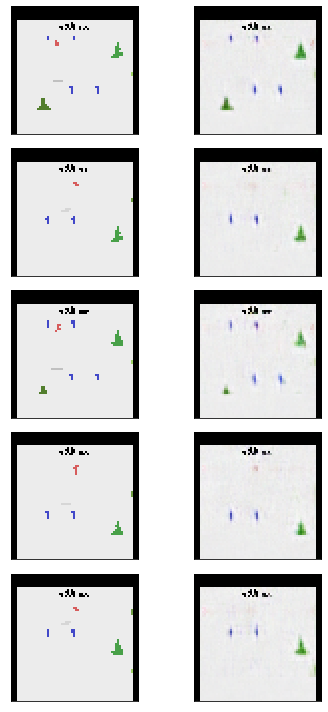

In [55]:
import random
idx = 0
obs = obs_test_downsampled[idx*batch_size:(idx+1)*batch_size,:,:,:]
pred = vae.decode(vae.encode(obs))

n = 5
_, ax = plt.subplots(n,2, figsize=(6,10))

for i, ind in enumerate(random.sample(range(batch_size), n)):
    # display original
    ax[i,0].imshow(obs[ind,:,:,:].reshape(64, 64, 3))
    ax[i,0].get_xaxis().set_visible(False)
    ax[i,0].get_yaxis().set_visible(False)
    
    # display reconstruction
    ax[i,1].imshow(pred[ind,:,:,:].reshape(64, 64, 3))
    ax[i,1].get_xaxis().set_visible(False)
    ax[i,1].get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()
    
    

In [21]:
print(pred[0,0:3,0:3,1])
print(pred[1,0:3,0:3,1])


[[0.00273782 0.01779109 0.00066167]
 [0.02952516 0.02207273 0.01081869]
 [0.00900897 0.00176266 0.00655752]]
[[0.00268787 0.01756355 0.00064689]
 [0.02919111 0.02182928 0.01067317]
 [0.00887531 0.0017308  0.00647444]]


In [56]:

mu, logvar = vae.encode_mu_logvar(obs_test_downsampled[1,:,:,:].reshape(1,64,64,3))
print(mu.shape)
print(logvar.shape)



(1, 32)
(1, 32)


In [24]:
print(downsampled.shape)

    
mu, logvar = vae.encode_mu_logvar(downsampled[1,:,:,:].reshape((1,64,64,3)))
print(mu.shape)
print(logvar.shape)

input = np.zeros((downsampled.shape[0]-1, mu.shape[1]+logvar.shape[1]+1)) #mu+logvar+action of t
result = np.zeros((downsampled.shape[0]-1, mu.shape[1]+logvar.shape[1])) #mu+logvar of t+1
print(input.shape)
print(result.shape)


(1566, 64, 64, 3)
(1, 32)
(1, 32)
(1565, 65)
(1565, 64)


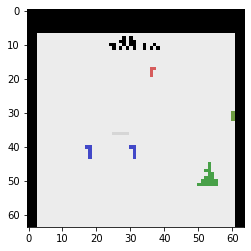

(64, 64, 64, 3)
(1, 64)
[array([0]) 2 1 ... 2 0 1]


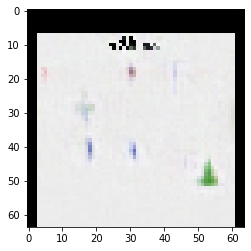

In [67]:
ind = 20
mu, logvar = vae.encode_mu_logvar(downsampled[ind,:,:,:].reshape((1,64,64,3)))
plt.imshow(downsampled[ind,:,:,:])
plt.show()

decoded_img = vae.decode_mu_logvar(mu, logvar)
print(decoded_img.shape)
plt.imshow(decoded_img[ind,:,:,:].reshape(64, 64, 3))
plt.show()
a = np.concatenate((mu, logvar),axis=1)
print(a.shape)
print(actions)


In [6]:

game_name = "Skiing"
output = "v0"


import os
record_files = [filename for filename in os.listdir(f'./record/{game_name}')
                    if os.path.isfile(f"./record/{game_name}/{filename}") and filename.startswith(f"record_{game_name}")]

input = []
output = []

for file in record_files[20:60]:
    print("load file: ", file)
    data = np.load(f"./record/{game_name}/{file}", allow_pickle=True)
    downsampled = data["obs_downsampled"]
    actions = data["actions"]
    rewards = data["rewards"]
    
    downsampled = downsampled / 255.
    
    current_input = np.zeros((downsampled.shape[0]-1, 65)) #mu+logvar+action of t
    current_output = np.zeros((downsampled.shape[0]-1, 64)) #mu+logvar of t+1

    for row in range(0,downsampled.shape[0]):
        value = vae.encode_mu_logvar(downsampled[row,:,:,:].reshape((1,64,64,3)))
        value = np.concatenate(value, axis=1)
        if row < downsampled.shape[0]-1:
            current_input[row,:-1] = value
            current_input[row,-1] = actions[row+1]
        if row > 0:
            current_output[row-1] = np.concatenate(value)
            
    if len(input) == 0:
        input = current_input
        output = current_output
    else:
        input = np.concatenate((input, current_input))
        output = np.concatenate((output, current_output))
    
    

load file:  record_Skiing_v0_26.npz
load file:  record_Skiing_v0_27.npz
load file:  record_Skiing_v0_28.npz
load file:  record_Skiing_v0_29.npz
load file:  record_Skiing_v0_3.npz
load file:  record_Skiing_v0_30.npz
load file:  record_Skiing_v0_31.npz
load file:  record_Skiing_v0_32.npz
load file:  record_Skiing_v0_33.npz
load file:  record_Skiing_v0_34.npz
load file:  record_Skiing_v0_35.npz
load file:  record_Skiing_v0_36.npz
load file:  record_Skiing_v0_37.npz
load file:  record_Skiing_v0_38.npz
load file:  record_Skiing_v0_39.npz
load file:  record_Skiing_v0_4.npz
load file:  record_Skiing_v0_40.npz
load file:  record_Skiing_v0_41.npz
load file:  record_Skiing_v0_42.npz
load file:  record_Skiing_v0_43.npz
load file:  record_Skiing_v0_44.npz
load file:  record_Skiing_v0_45.npz
load file:  record_Skiing_v0_46.npz
load file:  record_Skiing_v0_47.npz
load file:  record_Skiing_v0_48.npz
load file:  record_Skiing_v0_49.npz
load file:  record_Skiing_v0_5.npz
load file:  record_Skiing_v0_50

In [7]:
input_train = input[:int(len(input)*0.8),:]
input_test = input[int(len(input)*0.8):,:]
output_train = output[:int(len(output)*0.8),:]
output_test = output[int(len(output)*0.8):,:]


In [8]:
from keras.layers import Dense
from keras.models import Sequential
from keras import backend as K

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=65))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='linear'))
model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])


Using TensorFlow backend.


In [9]:
model.fit(input_train, output_train,
            epochs=100,
            batch_size=100,
            shuffle=True,
            validation_data=(input_test, output_test))


Train on 52568 samples, validate on 13143 samples
Epoch 1/100
52568/52568 [==============================] - 2s 46us/step - loss: 0.0921 - mean_squared_error: 0.0921 - val_loss: 0.0417 - val_mean_squared_error: 0.0417
Epoch 2/100
52568/52568 [==============================] - 2s 34us/step - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 3/100
52568/52568 [==============================] - 2s 35us/step - loss: 0.0291 - mean_squared_error: 0.0291 - val_loss: 0.0262 - val_mean_squared_error: 0.0262
Epoch 4/100
52568/52568 [==============================] - 2s 33us/step - loss: 0.0272 - mean_squared_error: 0.0272 - val_loss: 0.0249 - val_mean_squared_error: 0.0249
Epoch 5/100
52568/52568 [==============================] - 2s 35us/step - loss: 0.0261 - mean_squared_error: 0.0261 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 6/100
52568/52568 [==============================] - 2s 35us/step - loss: 0.0253 - mean_squared_error: 0

In [10]:

obs = input_test
obs_out = output_test
img = vae.decode_mu_logvar(obs[ind,:32], obs[ind,32:-1])
plt.imshow(img)
plt.show()

img = vae.decode_mu_logvar(obs_out[ind,:32], obs_out[ind,32:])
plt.imshow(img)
plt.show()


pred = model.predict(input[ind])
img = vae.decode_mu_logvar(pred[:32], pred[32:])
plt.imshow(img)
plt.show()


NameError: name 'ind' is not defined

In [ ]:
import random
idx = 0
obs = input_test
obs_out = output_test
pred = vae.decode(vae.encode(obs))

n = 5
_, ax = plt.subplots(n,3, figsize=(6,10))

for i, ind in enumerate(random.sample(range(batch_size), n)):
    # display original
    img = vae.decode_mu_logvar(obs[ind,:32], obs[ind,32:-1])
    ax[i,0].imshow(img.reshape(64, 64, 3))
    ax[i,0].get_xaxis().set_visible(False)
    ax[i,0].get_yaxis().set_visible(False)
    
    
    # display original reconstruction
    img = vae.decode_mu_logvar(obs_out[ind,:32], obs_out[ind,32:])
    ax[i,1].imshow(img.reshape(64, 64, 3))
    ax[i,1].get_xaxis().set_visible(False)
    ax[i,1].get_yaxis().set_visible(False)
    
    # display predicted reconstruction
    pred = model.predict(input[ind])
    img = vae.decode_mu_logvar(pred[:32], pred[32:])
    ax[i,1].imshow(,:,:,:].reshape(64, 64, 3))
    ax[i,1].get_xaxis().set_visible(False)
    ax[i,1].get_yaxis().set_visible(False)
    
    
plt.tight_layout()
plt.show()